<h1>Udacity Self-Driving Car Nanodegree Program</h1>


<h2>Advanced Lane Finding Project</h2>
    
<b>The steps of this project are the following::</b>

<ol>
    <li>Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.</li>
    <li>Apply a distortion correction to raw images.</li>
    <li>Use color transforms, gradients, etc., to create a thresholded binary image.</li>
    <li>Apply a perspective transform to binary image ("birds-eye view").</li>
    <li>Detect lane pixels and fit to find the lane boundary.</li>
    <li>Determine the curvature of the lane and vehicle position with respect to center.</li>
    <li>Warp the detected lane boundaries back onto the original image.</li>
    <li>Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.</li>
</ol>

In [8]:
# import all needed libraries
import numpy as np 
import cv2 
import glob
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.gridspec as gridspec
from moviepy.editor import VideoFileClip
import os 
import pickle

%matplotlib inline

<h3>Camera Calibration and Undistortion of Images</h3>

In [9]:
nx = 9
ny = 6
img_dir_path = './camera_cal/calibration*.jpg'

# Make a list of calibration images
images = glob.glob(img_dir_path)
    
def find_img_obj_points():
    # 1. Prepare object points like (0,0,0), (1,0,0), ..., (8,5,0)
    objp = np.zeros((ny*nx,3), np.float32)
    objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2) #x,y coordinates 

    # 2. Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.
    image_size = None
    
    # 3. Create a figure for plotting imgs
    f, axes = plt.subplots(1,2,figsize=(30,30))
    
    # 4. Step through the list and search for chessboard corners
    for i, fname in enumerate(images):
        origin_img = cv2.imread(fname)
        if i==2: 
            image_size = (origin_img.shape[0], origin_img.shape[1])
            # Plotting the original Image
            axes[0].set_title('Original Image', fontsize=20)
            axes[0].imshow(origin_img)
        gray = cv2.cvtColor(origin_img, cv2.COLOR_BGR2GRAY)
        # Find the chessboard corners in distorted img
        ret, corners = cv2.findChessboardCorners(gray, (nx,ny),None)
        
        # If found, add object points, image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)
            # Draw and display the corners
            cv2.drawChessboardCorners(origin_img, (nx,ny), corners, ret)
            if i==2: 
                # Plotting original Image with Chessboard Corners
                axes[1].set_title('Image with Chessboard Corners', fontsize=20)
                axes[1].imshow(origin_img)
        
    return objpoints, imgpoints, image_size

In [10]:
def calc_calibration_params():
    """Calculate and return camera matrix and distortion coefficients."""
    path = "camera_cal/dist_pickle.p"
    dist_pickle = {}
    
    if not os.path.isfile(path): 
        obj_points, img_points, img_shape = find_img_obj_points()
        ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(obj_points, img_points, img_shape, None, None)
 
        dist_pickle["mtx"] = mtx
        dist_pickle["dist"] = dist
        pickle.dump(dist_pickle, open(path, "wb"));
    else: 
        dist_pickle = pickle.load(open("camera_cal/dist_pickle.p", "rb" ))
        mtx = dist_pickle["mtx"]
        dist = dist_pickle["dist"]
    
    return mtx, dist

In [11]:
def undistort(image):

    mtx, dist = calc_calibration_params()
    dst_img = cv2.undistort(image, mtx, dist, None, mtx)
    return dst_img

Text(0.5, 1.0, 'Undistorted Image')

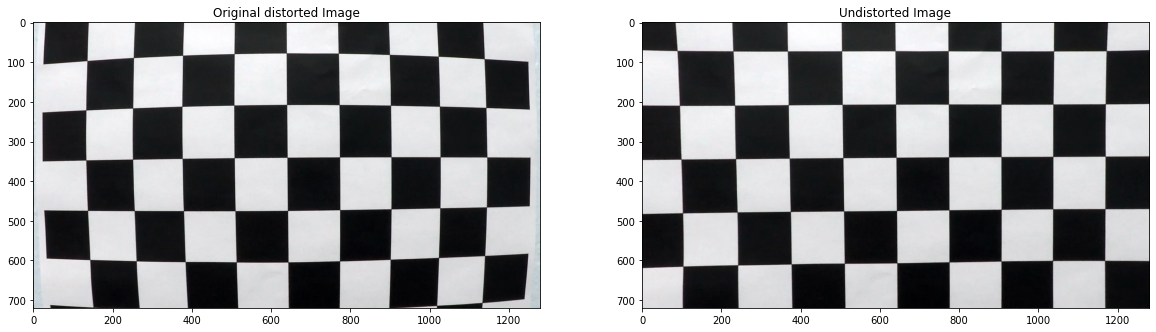

In [12]:
origin_img = cv2.imread(images[6])
undist_img = undistort(origin_img)

fig, axes = plt.subplots(ncols=2, figsize=(20, 10))
axes[0].imshow(origin_img)
axes[0].set_title('Original distorted Image')
axes[1].imshow(undist_img)
axes[1].set_title('Undistorted Image')

<h3>Create thresholded binary Image </h3>

<h6> Building the printing pipeline for better readability and maitenance </h6>

In [13]:
def bgr_to_rgb(img):
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

def plotter(test_img, new_img, plot_title=None, n=0):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
    f.tight_layout()
    matplotlib.rc('xtick', labelsize=15) 
    matplotlib.rc('ytick', labelsize=15)
    ax1.imshow(test_img)
    ax1.set_title('Original Image:', fontsize=15)
    ax2.imshow(new_img, cmap='gray')
    ax2.set_title('{0} Test {1}:'.format(plot_title, n+1), fontsize=15)

In [101]:
def pipeline(op=None):
    
    test_images = []
    test_imgs_all = glob.glob('test_images/test*.jpg')
    # use only the first two images for tests
    test_images.append(test_imgs_all[0])
    test_images.append(test_imgs_all[5])

    print ('test_images ', len(test_images))
    n = 0
    for img in test_images:
        img = cv2.imread(img)
        bgr_img = bgr_to_rgb(img)
        if op == 'Lane Mapping':            
            undistorted = undistort(img)
            thresholded = combined_threshold(undistorted) 
            binary_warped = original2bird_eye(thresholded)
            lines_img, pl, lfx, rfx, lf, rf, lli, rli =  sliding_window(binary_warped, plot=False)

            final_img = draw_green_lanes(img, binary_warped, lf, rf)

            plotter(bgr_img, cv2.cvtColor(final_img, cv2.COLOR_BGR2RGB), op, n)
            plt.savefig('output_images/lane_mapping.png'.format(op), bbox_inches="tight")
        if op == 'Undistorted':
            new_img = undistort(img)
            plotter(bgr_img, cv2.cvtColor(new_img, cv2.COLOR_BGR2RGB), op, n)
            plt.savefig('output_images/undistorted.png'.format(op), bbox_inches="tight")
            #break
        if op == 'Sobel X':
            new_img = undistort(img)
            new_img = abs_sobel_thresh(img,thresh=(35,255))
            plotter(bgr_img, new_img, op, n)
            plt.savefig('output_images/sobel_x.png'.format(op), bbox_inches="tight")
            break
        if op == 'Sobel Y':
            new_img = undistort(img)
            new_img = abs_sobel_thresh(img,orient='y',thresh=(35,255))
            plotter(bgr_img, new_img, op, n)
            plt.savefig('output_images/sobel_y.png'.format(op), bbox_inches="tight")
            break
        if op == 'Gradient Magnitude':
            new_img = undistort(img)
            new_img = mag_thresh(img)
            plotter(bgr_img, new_img, op, n)
            plt.savefig('output_images/gradient_magnitude.png'.format(op), bbox_inches="tight")
            break
        if op == 'Gradient Direction':
            new_img = undistort(img)
            new_img = dir_threshold(img)
            plotter(bgr_img, new_img, op, n)
            plt.savefig('output_images/gradient_direction.png'.format(op), bbox_inches="tight")
            break
        if op == 'Color Thresholds':
            new_img = undistort(img)
            new_img = hls_select(img)
            plotter(bgr_img, new_img, op, n)
            plt.savefig('output_images/color_thresholds.png'.format(op), bbox_inches="tight")
            break
        if op == 'Multi-Thresholded Binary':
            new_img = undistort(img)
            new_img = combined_threshold(new_img)
            plotter(bgr_img, new_img, op, n)
            plt.savefig('output_images/thresholded_binary.png'.format(op), bbox_inches="tight")
            #break
        if op == 'Region Masking':
            new_img = undistort(img)
            new_img = combined_thresholds(new_img)
            new_img = region_of_interest(new_img)
            plotter(bgr_img, new_img, op, n)
            plt.savefig('output_images/region_masked.png'.format(op), bbox_inches="tight")
            #break
        if op == 'Perspective Transform':
            new_img = undistort(img)
            new_img = combined_threshold(new_img)
            #new_img = region_of_interest(new_img)
            new_img = original2bird_eye(new_img)
            plotter(bgr_img, new_img, op, n)
            plt.savefig('output_images/perspective_transform.png'.format(op), bbox_inches="tight")
            #break
        if op == 'Sliding Window':
            new_img = undistort(img)
            binary_img= combined_threshold(new_img)
            binary_warped= original2bird_eye(binary_img)
            
            out_img, left_fit, right_fit, left_fitx, right_fitx = find_lines(binary_warped, plot=True)
            
            plotter(bgr_img, out_img, op, n)
            ploty = np.linspace(0, binary_warped.shape[0] - 1, binary_warped.shape[0])
            plt.plot(left_fitx, ploty, color='yellow')
            plt.plot(right_fitx, ploty, color='yellow')
            plt.xlim(0, 1280)
            plt.ylim(720, 0)
            plt.savefig('output_images/sliding_windows.png'.format(op), bbox_inches="tight")
            #break
        if op == 'Shaded Lanes':
            undistorted_img = undistort(img)
            thresholded_img = combined_threshold(undistorted_img)
            bird_eyed_img= original2bird_eye(thresholded_img)
            #def use_last_frame(binary_warped, left_fit, right_fit):
            _, left_fit, right_fit, _, _ = find_lines(bird_eyed_img, plot=False)

            left_fitx, right_fitx, pl, _, _, _, _, _, _, lli, rli = use_last_frame(bird_eyed_img,left_fit,right_fit)
            #out_img, left_fit, right_fit, left_fitx, right_fitx = find_lines(bird_eyed_img, plot=True)
            shaded_img = visualize_lane_lines(bird_eyed_img,left_fitx, right_fitx, pl,lli,rli) 
            #def visualize_lane_lines(binary_warped, left_fitx, right_fitx, ploty, left_lane_inds, right_lane_inds):
            plotter(bgr_img, shaded_img, op, n)
            plt.plot(left_fitx, pl, color='yellow')
            plt.plot(right_fitx, pl, color='yellow')
            plt.xlim(0, 1280)
            plt.ylim(720, 0)
            plt.savefig('output_images/shaded_lanes.png'.format(op), bbox_inches="tight")
            #break
        if op == 'Radius of Curvature in Pixels':
            new_img = undistort(img)
            new_img = combined_thresholds(new_img)
            new_img, M, Minv = transform_perspective(new_img)
            windows_img, ploty, left_fitx, right_fitx, left_fit, right_fit, leftx, rightx,leftx_base, rightx_base = sliding_windows(new_img)
            left_curverad, right_curverad = roc_in_pixels(ploty, left_fit, right_fit, leftx, rightx)
            print('Test Image {0}\nLeft Radius of Curvature: {1:2f} pixels\nRight Radius of Curvature: {2:2f} pixels\n'.format(n+1, left_curverad, right_curverad))
            break
        if op == 'Radius of Curvature in Meters':
            new_img = undistort(img)
            new_img = combined_thresholds(new_img)
            new_img, M, Minv = transform_perspective(new_img)
            windows_img, ploty, left_fitx, right_fitx, left_fit, 
            right_fit, leftx,rightx, leftx_base, rightx_base = sliding_windows(new_img)
            left_curverad, right_curverad = roc_in_meters(ploty, left_fit, right_fit, leftx, rightx)
            print('Test Image {0}\nLeft Radius of Curvature: {1:2f} meters\nRight Radius of Curvature: {2:2f} meters\n'.format(n+1, left_curverad, right_curverad))
            break

        if op == "Histogram":
            img = undistort(img)
            img = original2bird_eye(img)
            f, axes= plt.subplots(1,3,figsize=(20,5))
            index=0
            img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
            axes[0].imshow(img)
            axes[0].set_title("Original Wraped Image",fontsize=15)
            combinedImage=combined_threshold(img)
            axes[1].imshow(combinedImage,cmap="gray")
            axes[1].set_title("Thresholded Binary Image",fontsize=15)
            histogram = get_histogram(combinedImage)
            axes[2].plot(histogram)
            axes[2].set_title("Histogram",fontsize=15)

        if op == 'Image Pipeline': 
            final_img = img_pipeline(img)
            plotter(bgr_img, cv2.cvtColor(final_img, cv2.COLOR_BGR2RGB), op, n)
            plt.savefig('output_images/pipeline.png'.format(op), bbox_inches="tight")

            
        n += 1

<h6> Functions to work with direvatives of images in x and y directions. </h6>


In [17]:
# function to return thresholded gradient based binary output 
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0,255)): 
    # 1. Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    # 2. Take the derivative in x or y given orient = 'x' or 'y'
    if orient == 'x': 
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    else: 
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    
    # 3. Take the absolute value of the derivative or gradient
    abs_sobel = np.absolute(sobel)
    
    # 4. Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel = np.uint8(abs_sobel * 255 / np.max(abs_sobel))
    
    # 5. Threshold the scaled_sobel and create a binary output
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel > thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    
    return binary_output

test_images  2


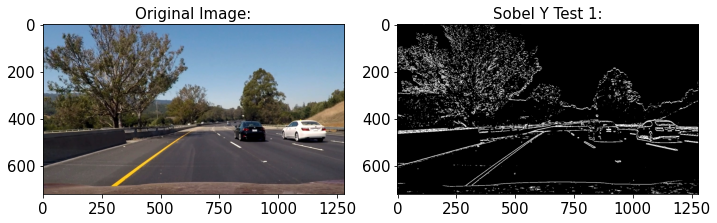

In [18]:
pipeline(op='Sobel Y')

test_images  2


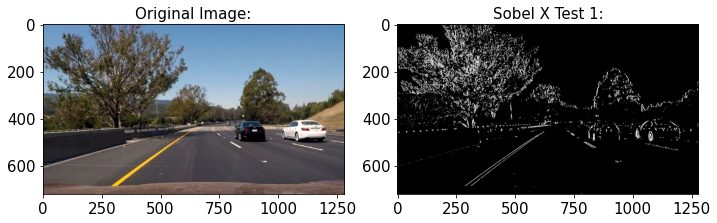

In [19]:
pipeline(op='Sobel X')

In [20]:
# function to return magnitute of derivatives thresholded binary output
def mag_thresh(img, sobel_kernel=3, thresh=(50,255)): 
    # 1. Convert to grayscale 
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    # 2. Take the gradient in x and y separately 
    sobel_x = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobel_y = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    
    # 3. Calculate the magnitude
    magnitude = np.sqrt(sobel_x ** 2 + sobel_y ** 2)
    
    # 4. Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_mag = np.uint8(magnitude * 255 / np.max(magnitude))
    
    # 5. Create a binary mask where magnitude thresholds are met 
    binary_output = np.zeros_like(scaled_mag)
    binary_output[(scaled_mag > thresh[0]) & (scaled_mag <= thresh[1])] = 1
    
    return binary_output

test_images  2


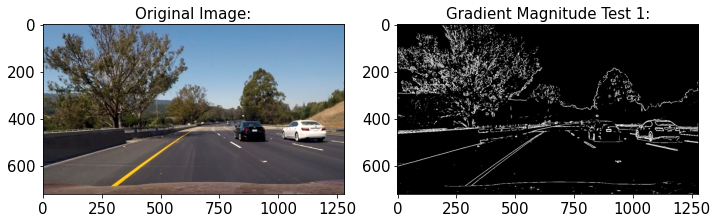

In [21]:
pipeline(op='Gradient Magnitude')

In [22]:
# function to return direction of derivatives thresholded binary output
def dir_threshold(img, sobel_kernel=3, thresh=(0.7, 1.1)):
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)

    # 3) Take the absolute value of the x and y gradients
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)

    # 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient
    dir_grad = np.arctan2(abs_sobely, abs_sobelx)

    # 5) Create a binary mask where direction thresholds are met
    binary_output = np.zeros_like(gray)
    binary_output[(dir_grad >= thresh[0]) & (dir_grad <= thresh[1])] = 1

    return binary_output

test_images  2


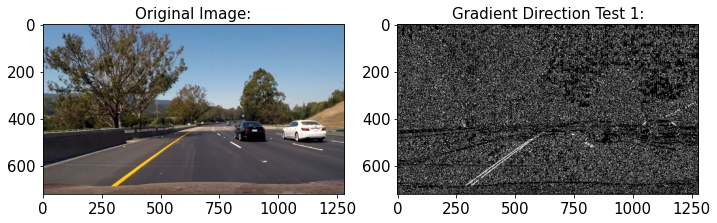

In [23]:
pipeline(op='Gradient Direction')

In [24]:
# Get pixel values for white colors from all RGB channels 
def rgb_white(img):
    r, g, b = img[:, :, 0], img[:, :, 1], img[:, :, 2]

    binary_output = np.zeros_like(r)
    binary_output[(r >= 210) & (g >= 200) & (b >= 190)] = 1
    return binary_output

# Filter out the lower pixel values in all RGB channels to avoid shadow
def suppress_shadow(img):
    r, g, b = img[:, :, 0], img[:, :, 1], img[:, :, 2]

    binary_output = np.zeros_like(r)
    binary_output[(r > 30) | (g > 30) | (b > 30)] = 1
    return binary_output

# Convert RGB to HLS color space and return a thresholded channel
def hls_select(img, selected='s', thresh=(80, 255)):
    # 1) Convert to HLS color space
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)

    # 2) Apply a threshold to the selected channel
    idx = {'h': 0, 'l': 1, 's': 2}[selected.lower()]
    channel = hls[:, :, idx]

    binary_output = np.zeros_like(channel)
    binary_output[(channel > thresh[0]) & (channel <= thresh[1])] = 1
    return binary_output

test_images  2


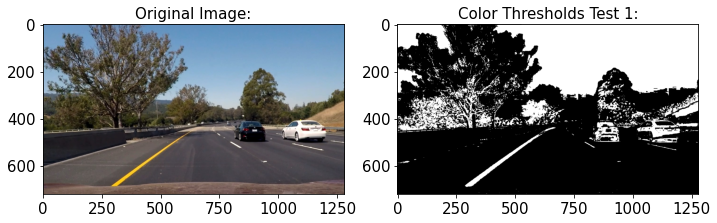

In [25]:
pipeline(op='Color Thresholds')

In [26]:
def combined_threshold(image):
    """return the binary warp result of the image"""
    ksize = 5

    # Apply each of the thresh-holding functions
    gradx = abs_sobel_thresh(image, orient='x', sobel_kernel=ksize, thresh=(50, 255))
    grady = abs_sobel_thresh(image, orient='y', sobel_kernel=ksize, thresh=(100, 255))
    s_channel = hls_select(image, selected='s', thresh=(180, 255)) & suppress_shadow(image)
    white = rgb_white(image)
    shadowed_yellow = hls_select(image, selected='h', thresh=(18, 63)) & \
                      hls_select(image, selected='s', thresh=(55, 255)) & \
                      hls_select(image, selected='l', thresh=(0, 140))

    combined = gradx | grady | s_channel | shadowed_yellow | white
    return combined

test_images  2


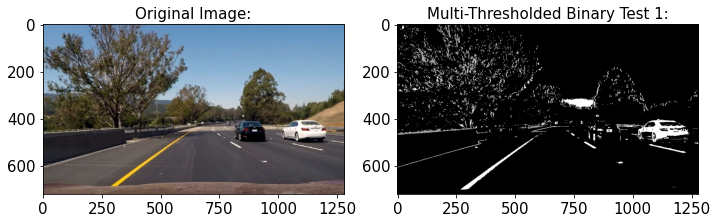

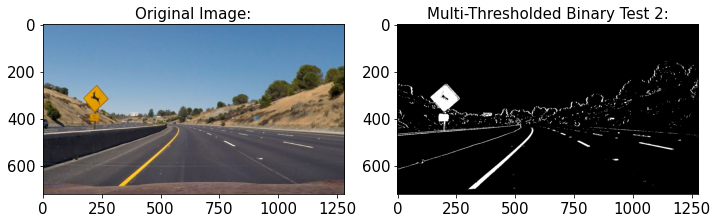

In [27]:
pipeline(op='Multi-Thresholded Binary')

<h3>Perspective Transform</h3> 

In [28]:
def bgr_to_rgb(img):
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

def plotter(test_img, new_img, plot_title=None, n=0):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
    f.tight_layout()
    matplotlib.rc('xtick', labelsize=15) 
    matplotlib.rc('ytick', labelsize=15)
    ax1.imshow(test_img)
    ax1.set_title('Original Image:', fontsize=15)
    ax2.imshow(new_img, cmap='gray')
    ax2.set_title('{0} Test {1}:'.format(plot_title, n+1), fontsize=15)

In [63]:
# Source matrix
src = np.array([[580, 460],
                [203, 720],
                [1127, 720],
                [705, 460]], dtype=np.float32)

# Target matrix to transform to
dst = np.array([[320, 0],
                [320, 720],
                [960, 720],
                [960, 0]], dtype=np.float32)

left_end, right_end = 250, 1080

# transform matrix
trans_matrix = cv2.getPerspectiveTransform(src, dst)
invert_matrix = cv2.getPerspectiveTransform(dst, src)

def original2bird_eye(image):
    return cv2.warpPerspective(image, trans_matrix, image.shape[1::-1], flags=cv2.INTER_LINEAR)


def bird_eye2original(image):
    return cv2.warpPerspective(image, invert_matrix, image.shape[1::-1], flags=cv2.INTER_LINEAR)

test_images  2


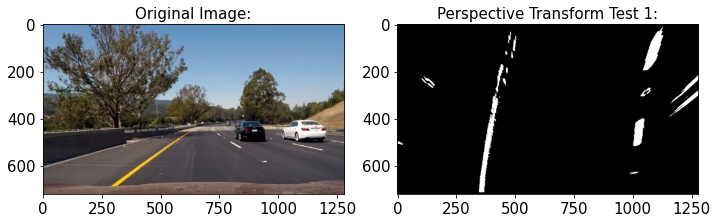

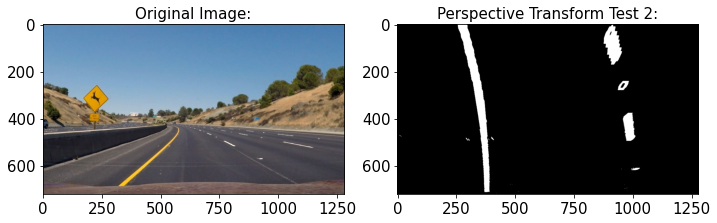

In [64]:
pipeline(op='Perspective Transform')


In [65]:
def get_histogram(warpedimage):
    return np.sum(warpedimage[warpedimage.shape[0]//2:,:], axis=0)

test_images  2


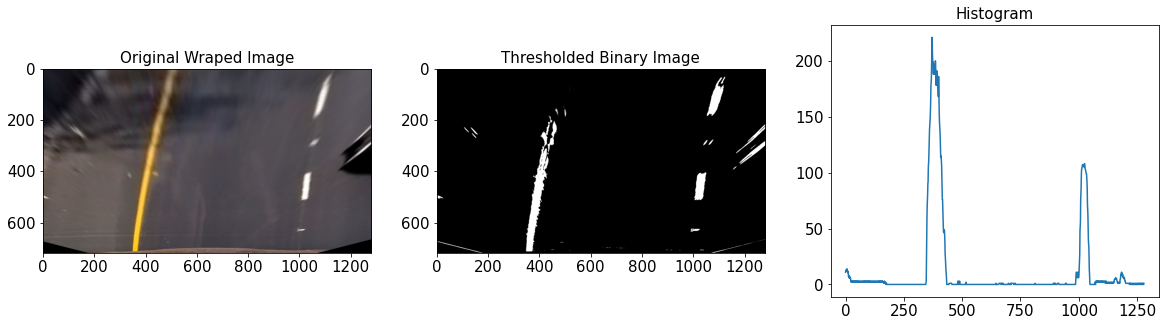

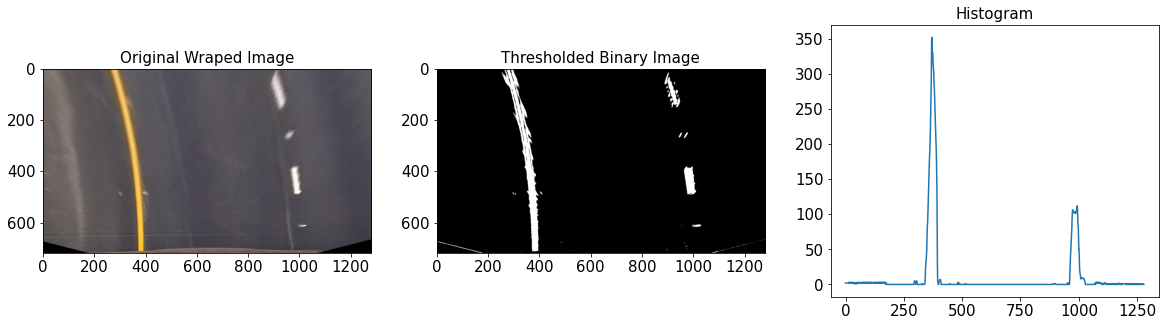

In [66]:
pipeline(op="Histogram")

In [67]:
# Set the hyperparameters

# Choose the number of sliding windows
nwindows = 9
# Set the width of the windows +/- margin
margin = 100
# Set minimum number of pixels found to recenter window
minpix = 50

# Method to get base points for left and right lanes
def get_lane_base_points(binary_warped): 
    # Take the histogram of bottom half of the image
    histogram = get_histogram(binary_warped)
    # Find the peaks of the left and right halves of the histogram 
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    return leftx_base, rightx_base, histogram

test = False

def find_lines(binary_warped, plot=False):

    # Make sure binary doesn't have float values
    binary_warped = binary_warped.astype('uint8')
    
    # Take a histogram of the bottom half of the image
    leftx_base, rightx_base, histogram = get_lane_base_points(binary_warped)
    
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines

    window_height = np.int(binary_warped.shape[0]/nwindows)

    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin

        if plot:
            # Draw the windows on the visualization image
            cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
            cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2)         
        
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    ploty = np.linspace(0, binary_warped.shape[0] - 1, binary_warped.shape[0])
    left_fitx = left_fit[0] * ploty ** 2 + left_fit[1] * ploty + left_fit[2]
    right_fitx = right_fit[0] * ploty ** 2 + right_fit[1] * ploty + right_fit[2]
    
    # Color the lane line point (left line: red, right line: blue)
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]  
        
    return out_img, left_fit, right_fit, left_fitx, right_fitx

test_images  2


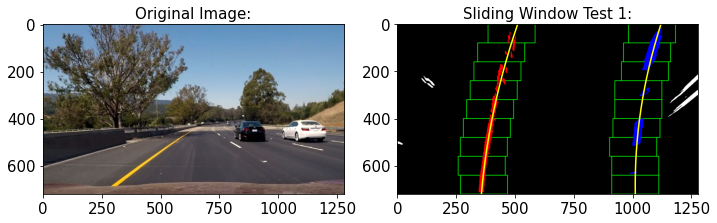

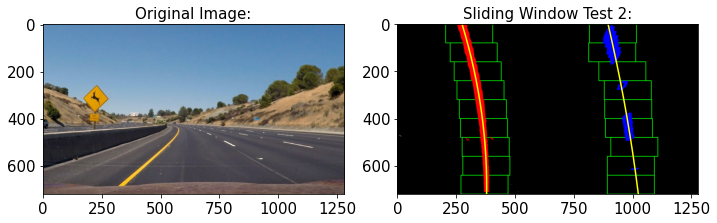

In [68]:
pipeline("Sliding Window")

In [69]:
def use_last_frame(binary_warped, left_fit, right_fit):

    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 30
    left_lane_inds = (
        (nonzerox > (left_fit[0] * (nonzeroy ** 2) + left_fit[1] * nonzeroy + left_fit[2] - margin)) &
        (nonzerox < (left_fit[0] * (nonzeroy ** 2) + left_fit[1] * nonzeroy + left_fit[2] + margin)))
    right_lane_inds = (
        (nonzerox > (right_fit[0] * (nonzeroy ** 2) + right_fit[1] * nonzeroy + right_fit[2] - margin)) &
        (nonzerox < (right_fit[0] * (nonzeroy ** 2) + right_fit[1] * nonzeroy + right_fit[2] + margin)))

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds]
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0] - 1, binary_warped.shape[0])
    left_fitx = left_fit[0] * ploty ** 2 + left_fit[1] * ploty + left_fit[2]
    right_fitx = right_fit[0] * ploty ** 2 + right_fit[1] * ploty + right_fit[2]
    
        
    return left_fitx, right_fitx, ploty, left_fit, right_fit, leftx, rightx, lefty, righty, left_lane_inds, right_lane_inds

<h4> Detect lane pixels and fit to find the lane boundary </h4>

In [70]:
def visualize_lane_lines(binary_warped, left_fitx, right_fitx, ploty, left_lane_inds, right_lane_inds):
    # Make sure binary doesn't have float values
    binary_warped = binary_warped.astype('uint8')
    
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                                  ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                                  ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    return result

test_images  2


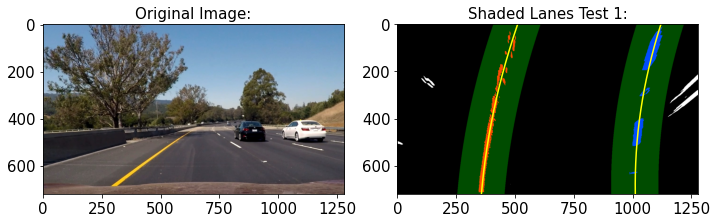

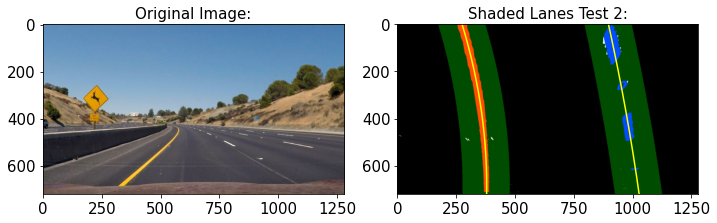

In [71]:
pipeline('Shaded Lanes')

In [72]:
def draw_green_lane(original_image, binary_warped, left_fit, right_fit):
    
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    h,w= binary_warped.shape
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    if len(left_fit) and len(right_fit):
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty +left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2] 
    



        ploty = np.linspace(0, h-1, num=h)# to cover same y-range as image

        # Recast the x and y points into usable format for cv2.fillPoly()
        pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
        pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
        pts = np.hstack((pts_left, pts_right))

        # Draw the lane onto the warped blank image
        cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
        cv2.polylines(color_warp, np.int32([pts_left]), isClosed=False, color=(255,0,255), thickness=15)
        cv2.polylines(color_warp, np.int32([pts_right]), isClosed=False, color=(0,255,255), thickness=15)

        # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, invert_matrix, (w, h)) 
    # Combine the result with the original image
    result = cv2.addWeighted(original_image, 1, newwarp, 0.5, 0)
    return result

In [73]:
#pipeline(op= 'Lane Mapping')

In [107]:
def calculate_curvature_radius(ploty, leftx, rightx, lefty, righty):
    
    y_eval = np.max(ploty)
    
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30 / 720  # meters per pixel in y dimension
    xm_per_pix = 3.7 / 700  # meters per pixel in x dimension

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(lefty * ym_per_pix, leftx * xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty * ym_per_pix, rightx * xm_per_pix, 2)

    # Calculate the new radii of curvature
    left_curve_radius = ((1 + (2 * left_fit_cr[0] * y_eval * ym_per_pix + left_fit_cr[1]) ** 2) ** 1.5) / np.absolute(
        2 * left_fit_cr[0])
    right_curve_radius = ((1 + (2 * right_fit_cr[0] * y_eval * ym_per_pix + right_fit_cr[1]) ** 2) ** 1.5) / np.absolute(
        2 * right_fit_cr[0])
    radius = np.mean([left_curve_radius, right_curve_radius])

    left_y_max = np.argmax(lefty)
    right_y_max = np.argmax(righty)
    center_x = (leftx[left_y_max] + rightx[right_y_max])/2
    center_offset = (640 - center_x) * xm_per_pix
    
    
    return radius, center_offset

In [112]:
first = True
count = 0

def img_pipeline(image):
    
    undist = undistort(image)

    warped = original2bird_eye(undist)
    warped_binary = combined_threshold(warped)
    
    global first, left_fitx, right_fitx, ploty, left_fit, right_fit, leftx, rightx, lefty, righty
    if first:
     
        out_img, left_fit, right_fit, left_fitx, right_fitx = find_lines(warped_binary)
        left_fitx, right_fitx, ploty, left_fit, right_fit, leftx, rightx, lefty, righty, _, _ = use_last_frame(warped_binary, left_fit, right_fit)
        first = False
        #left_fitx, right_fitx, ploty, left_fit, right_fit, leftx, rightx, lefty, righty, left_lane_inds, right_lane_inds
    left_fitx, right_fitx, ploty, left_fit, right_fit, leftx, rightx, lefty, righty, _, _ = use_last_frame(warped_binary, left_fit, right_fit)
    
    radius, center_offset = calculate_curvature_radius(ploty, leftx, rightx, lefty, righty)
    
    result = draw_green_lane(image,warped_binary, left_fit, right_fit)

    cv2.putText(result, 'Radius: {0:.1f}m '.format(np.add.reduce(radius)), (50, 50), 
                cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 0), 2, bottomLeftOrigin=False)
    cv2.putText(result, 'Center Offset: {0:.2f}m'.format(np.add.reduce(center_offset)), (50, 100),
                cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 0), 2, bottomLeftOrigin=False)
    
    return result

test_images  2


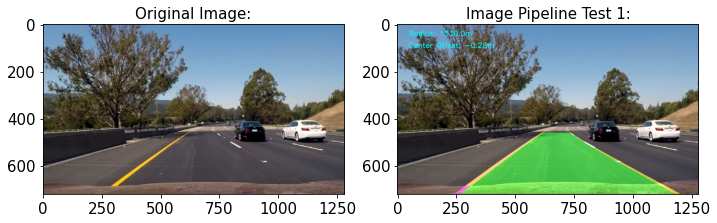

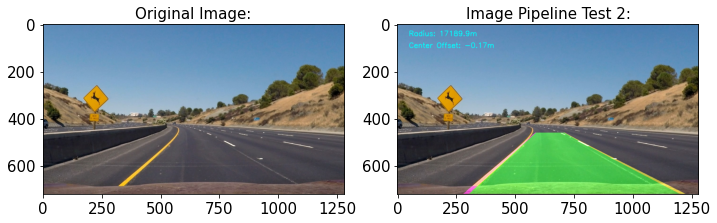

In [113]:
pipeline(op='Image Pipeline')

In [114]:
def video_pipeline(video_file, output_file, process_method):
    """
    :param     video_file: source video file path
    :param    output_file: output video file path
    :param process_method: the callback function which is used to process the video per frame
    :return:
    """
    clip = VideoFileClip(video_file)
    processed_clip = clip.fl_image(process_method)  # NOTE: this function expects color images!!
    processed_clip.write_videofile(output_file, audio=False);

In [115]:
video_pipeline("project_video.mp4", "project_video_out4.mp4", img_pipeline);

t:   0%|          | 2/1260 [00:00<01:07, 18.74it/s, now=None]

Moviepy - Building video project_video_out4.mp4.
Moviepy - Writing video project_video_out4.mp4



Moviepy - Done !
Moviepy - video ready project_video_out4.mp4


In [118]:
from IPython.display import Markdown, display
display(Markdown("writeup_template.md"))

## Project: Advanced Lane Finding

### Goals:

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

[//]: # (Image References)

[image1]: ./output_images/undistorted_chess.png "Undistorted"
[image1_2]: ./output_images/undistorted.png "Undistorted"
[image2_1]: ./output_images/sobel_x.png "Sobel X"
[image2_2]: ./output_images/sobel_y.png "Sobel Y"
[image2_3]: ./output_images/gradient_magnitude.png "Magnitude"
[image2_4]: ./output_images/gradient_direction.png "Direction"
[image3]: ./output_images/perspective_transform.png "Perspective Transform"
[image4]: ./output_images/histogram2.png "Histogram"
[image5]: ./output_images/sliding_windows.png "Sliding Window"
[image6]: ./output_images/pipeline.png "Fit Visual"
[image7]: ./examples/example_output.jpg "Output"
[video1]: ./project_video.mp4 "Video"

## [Rubric](https://review.udacity.com/#!/rubrics/571/view) Points

### Here I will consider the rubric points individually and describe how I addressed each point in my implementation.  

---

### Camera Calibration

#### 1. Briefly state how you computed the camera matrix and distortion coefficients. Provide an example of a distortion corrected calibration image.

For the image calibration the OpenCV offers the relevant functions like `findChessboardCorners` and `calibrateCamera`.
As input there are a number of images of a chessboard, taken from different angles with the same camera. The function `findChessboardCorners` is used to store the corners points in an array `image points` for each calibration image where the chessboard could be found. The `object points` will always be the same as the known coordinates of the chessboard with zero as 'z' coordinate because the chessboard is flat. The object points are then stored in an array called `objpoints`. The object and images points are fed to `calibrateCamera`, which return camera calibration and distortion coefficients. We use than the OpenCV `undistort` function to undo the effects of distortion on any image produced by the same camera. 
The following result was obtained using the desribed procedure: 


![alt text][image1]

### Pipeline (single images)

#### 1. Example of a distortion-corrected image.

To apply the distortion correction the function undistort were implemented: 
```python
def undistort(image):
    mtx, dist = calc_calibration_params()
    dst_img = cv2.undistort(image, mtx, dist, None, mtx)
    return dst_img
```
To demonstrate this step, I will describe how I apply the distortion correction to one of the test images like this one:
![alt text][image1_2]

#### 2. Creation of binary image:

I used a combination of color and gradient thresholds to generate a binary image.
For each substep I've implemented a separate function: 

##### 2.1 Taking image gradients in x and y directions
The function `abs_sobel_thresh()` returns based on the input parameter either gradient in x or y direction and sets thresholds to identify pixels within a certain gradient range.
The following pictures demonstrates both methods: 

###### Gradient in x direction: Sobel X
![alt text][image2_1]
###### Gradient in x direction: Sobel Y
![alt text][image2_2]

(thresholding steps at lines # through # in `another_file.py`).  Here's an example of my output for this step.  (note: this is not actually from one of the test images)

##### 2.2 Taking magnitude of  gradient in both in x and y direction

The function `mag_thresh()` calculates the magnitude of the gradient, in both x and y and applies a threshold to this overall magnitude. The magnitude, or absolute value, of the gradient is just the square root of the squares of the individual x and y gradients, which are returned by previously described function `abs_sobel_thresh()`. 
The below images shows the applied thresholded magnitude of derivatives: 

![alt text][image2_3]

##### 2.3 Taking direction of  gradient
In the case of lane lines, we're interested only in edges of a particular orientation. The function `dir_thresh` computes the direction, or orientation, of the gradient and applies a defined threshold.
The direction of the gradient is simply the inverse tangent (arctangent) of the `y` gradient divided by the `x` gradient:

![alt text][image2_4]
#### 3. Describe how (and identify where in your code) you performed a perspective transform and provide an example of a transformed image.

The code for my perspective transform includes a function called `original2bird_eye`.  This function takes as inputs an image (`img`). The source (`src`) and destination (`dst`) points were hardcoded and I used the following parameters:

```python
# Source matrix to define a Region Of Interest
src = np.array([[580, 460],
                [203, 720],
                [1127, 720],
                [705, 460]], dtype=np.float32)

# Target matrix to transform to
dst = np.array([[320, 0],
                [320, 720],
                [960, 720],
                [960, 0]], dtype=np.float32)
```

After defining the Region Of Interest, the next step is to warp the image using `original2bird_eye`, to see the image from bird's eye perspective. To do this we need to calculate a Matrix with the defined source and destination points: 

```python

trans_matrix = cv2.getPerspectiveTransform(src, dst) 
```
After calculating the Matrix we can now apply the OpenCV function `warpPerspective`  to get the final warped image:

![alt text][image3]

#### 4 Itentifying lane-line pixels and fitting their positions with a polynomial

##### 4.1 Creation of Histogram and finding its peaks
After applying calibration, thresholding, and a perspective transform to a road image, we now have a binary image where the lane lines stand out clearly so that the lane lines can be mapped out.
The first step of mapping out the lane lines is the create a Histogram of lower half of the image. 
```python

def get_histogram(warpedimage):
    return np.sum(warpedimage[warpedimage.shape[0]//2:,:], axis=0)
```
With this way we are able to find out a distinction between the left lane pixels and right lane pixels:
![alt text][image4]

##### 4.2 Sliding Window search

After finding the the two highest peaks from our histogram we can now use it as a starting point for determining where the lane lines are, and then use **sliding windows** moving upward in the image to determine where the lane lines go.

The sliding window is applied in following steps:

1. The left and right base points are calculated from the histogram
2. We then calculate the position of all non zero x and non zero y pixels.
3. We then Start iterating over the windows where we start from points calculate in point 1.
4. We then identify the non zero pixels in the window we just defined
5. We then collect all the indices in the list and decide the center of next window using these points
6. Once we are done, we seperate the points to left and right positions

##### 4.3 Fit a polynomial 
Now that we have found all our pixels belonging to each line through the sliding window method, it's time to fit a polynomial to the line using a second degree polynomial using with `np.polyfit`:
![alt text][image5]

#### 5. Describe how (and identify where in your code) you calculated the radius of curvature of the lane and the position of the vehicle with respect to center.

If we summarize all the described points, we now have a thresholded image, estimation which pixels belong to the left and right lane lines (shown in red and blue, respectively, in the image above) and a fitted polynomial to those pixel positions.
The next step is computation of the radius of curvature of the fit.

The implemented function `calculate_curvature_radius` returns the calculated curvature and vehicle's position on the center
that we computed as follows: 
Radius:

1. First we define values to convert pixels to meters
2. Plot the left and right lines
3. Calculate the curvature from left and right lanes seperately
4. Return mean of values calculated in step 3.

Vehicle's position on the center:

1. Calculate the lane center by evaluating the left and right polynomials at the maximum Y and find the middle point.
2. Calculate the vehicle center transforming the center of the image from pixels to meters.
3. The sign between the distance between the lane center and the vehicle center gives if the vehicle is on to the left or the right.

#### 6.  Example image of result plotted back down onto the road such that the lane area is identified clearly.

I implemented this in the function `draw_green_lane`. A polygon is generated based on plots of the left and right fits. The generated points are mapped back to the image space using the inverse transformation matrix generated by the perspective transformation in `bird_eye2original` function of my code. The image below is an example of the results of the `draw_green_lane` function:

![alt text][image6]

---

### Pipeline (video)

#### 1. Provide a link to your final video output.  Your pipeline should perform reasonably well on the entire project video (wobbly lines are ok but no catastrophic failures that would cause the car to drive off the road!).

Here's a [link to my video result](./project_video_out.mp4)
dfa
---

### Discussion

#### 1. Briefly discuss any problems / issues you faced in your implementation of this project.  Where will your pipeline likely fail?  What could you do to make it more robust?

Thoughts: 
The pipeline words fine on the project video and looks robust on changes on lighting conditions and other noises.


Here I'll talk about the approach I took, what techniques I used, what worked and why, where the pipeline might fail and how I might improve it if I were going to pursue this project further.  
